In [1]:
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
import shap
import joblib
from helper_files.modelling_functions import get_data
from helper_files.etv_model import ETVModel


/Users/bradeneberhard/miniforge3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Data and Model

In [2]:
data_path = '../data/processed/data_splits_1003.jblb'
train_df, test_df_time, test_df_random, test_df_thrower = get_data(data_path)
models = joblib.load('../data/models/xgb_models_auc.jblb')
etv_model = ETVModel(models['cp_model'], models['fv_model'])

Fit SHAP

In [3]:
X = test_df_random[models['cp_model']['features']].astype(float).iloc[:50000,:]
explainer = shap.Explainer(etv_model.predict, X)
etv_shap_values = explainer(X)
etv_shap_values.feature_names = [x.replace('_', ' ').replace('possession num', 'number of possessions in current point').replace('times', 'time left').replace('diff', 'differential').replace('possession throw', 'number of throws in current possession') for x in etv_shap_values.feature_names]
joblib.dump(etv_shap_values, './shap_values/etv_shap_values.jblb')

PermutationExplainer explainer: 50001it [3:02:11,  4.57it/s]                             


['./shap_values/etv_shap_values.jblb']

In [3]:
## load shap values it saved to save time
etv_shap_values = joblib.load('./shap_values/etv_shap_values.jblb')

Summary Plots

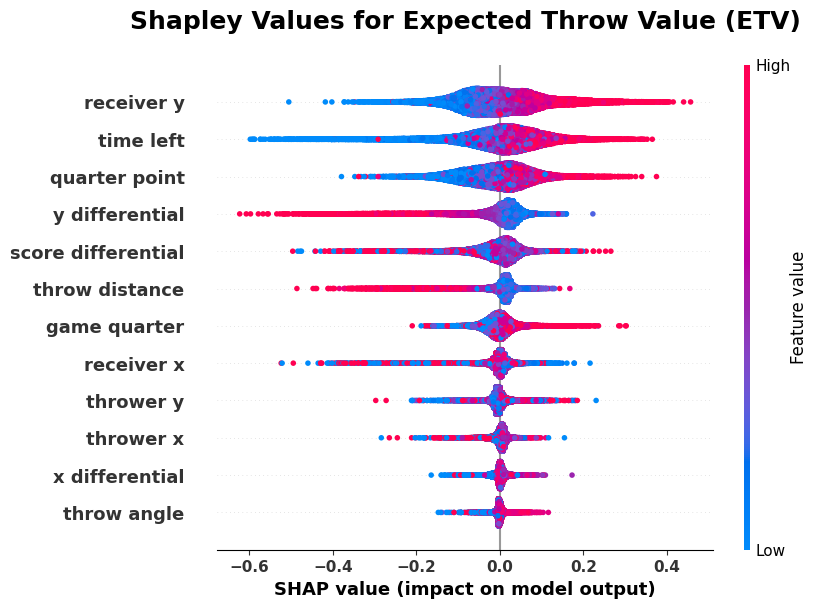

In [5]:
shap.plots.beeswarm(etv_shap_values, max_display=15, show=False, order=etv_shap_values.abs.mean(0))
plt.title("Shapley Values for Expected Throw Value (ETV)\n")
# Customize the plot to make text bold
plt.title(plt.gca().get_title(), fontweight='bold', fontsize=18)  # Make the title bold
plt.xlabel(plt.gca().get_xlabel(), fontweight='bold')  # Make the x-axis label bold
plt.ylabel(plt.gca().get_ylabel(), fontweight='bold')  # Make the y-axis label bold

# Set bold font for the tick labels
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()

Interaction Plots

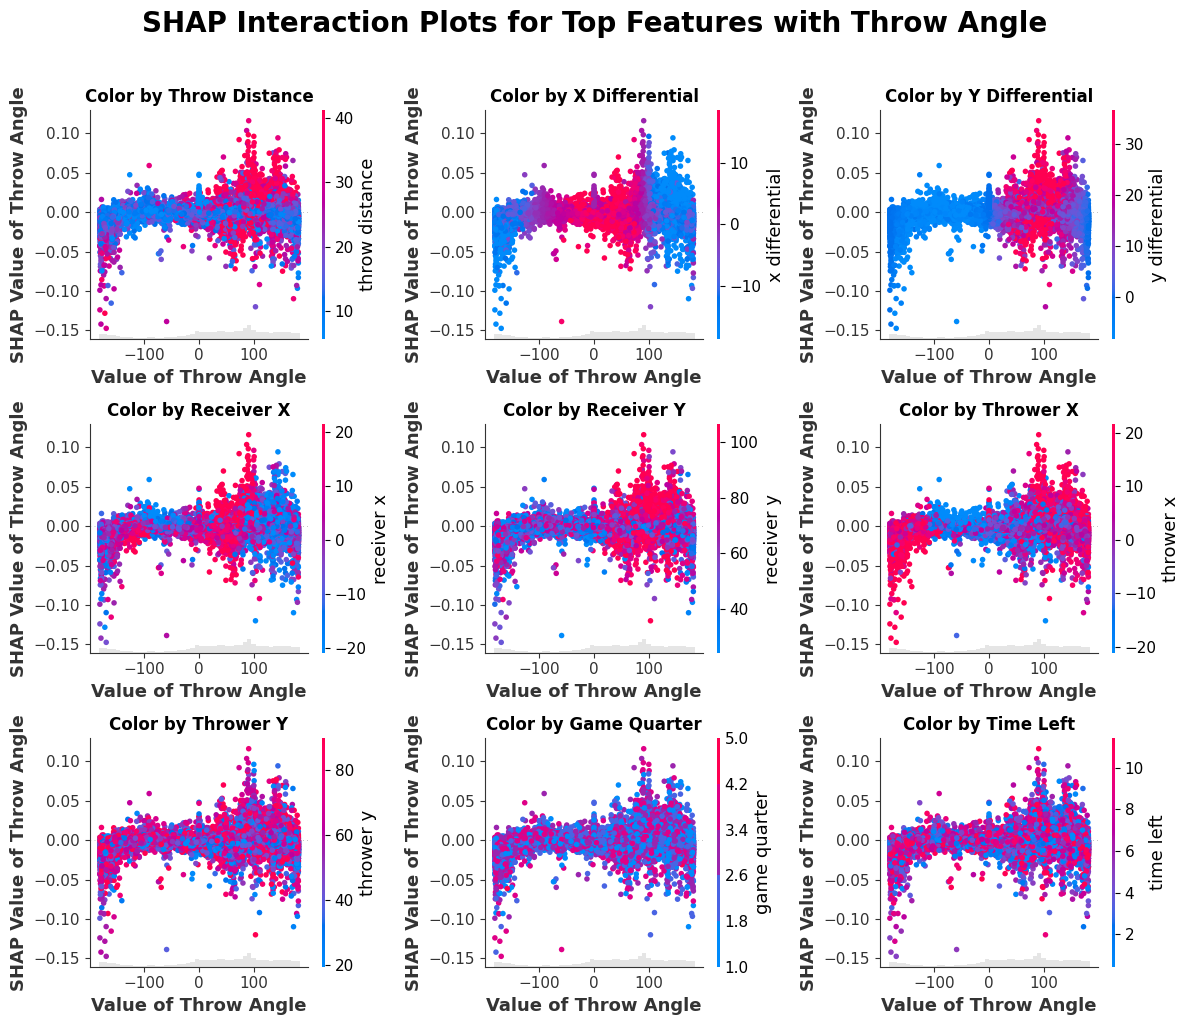

In [6]:
vals = etv_shap_values
feature='throw angle'
interaction_indices = shap.approximate_interactions(
    vals.feature_names.index(feature),
    vals.values,
    vals.data,
    feature_names=vals.feature_names
)
top_features_indices = interaction_indices[:9]
top_features = [vals.feature_names[i] for i in top_features_indices]

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
axes = axes.flatten()

for i, chosen_feature in enumerate(top_features):
    shap.plots.scatter(vals[:, feature], color=vals[:, chosen_feature], show=False, ax=axes[i])
    axes[i].set_title(f'Color by {chosen_feature.title()}', fontweight='bold')  # Bold title
    axes[i].set_xlabel(f'Value of {feature.title()}', fontweight='bold')  # Bold x-label
    axes[i].set_ylabel(f'SHAP Value of {feature.title()}', fontweight='bold')  # Bold y-label
    # axes[i].tick_params(labelweight='bold')  # Bold tick labels

plt.suptitle(f'SHAP Interaction Plots for Top Features with {feature.title()}', fontsize=20, fontweight='bold', y=1.02)  # Bold main title
plt.tight_layout()

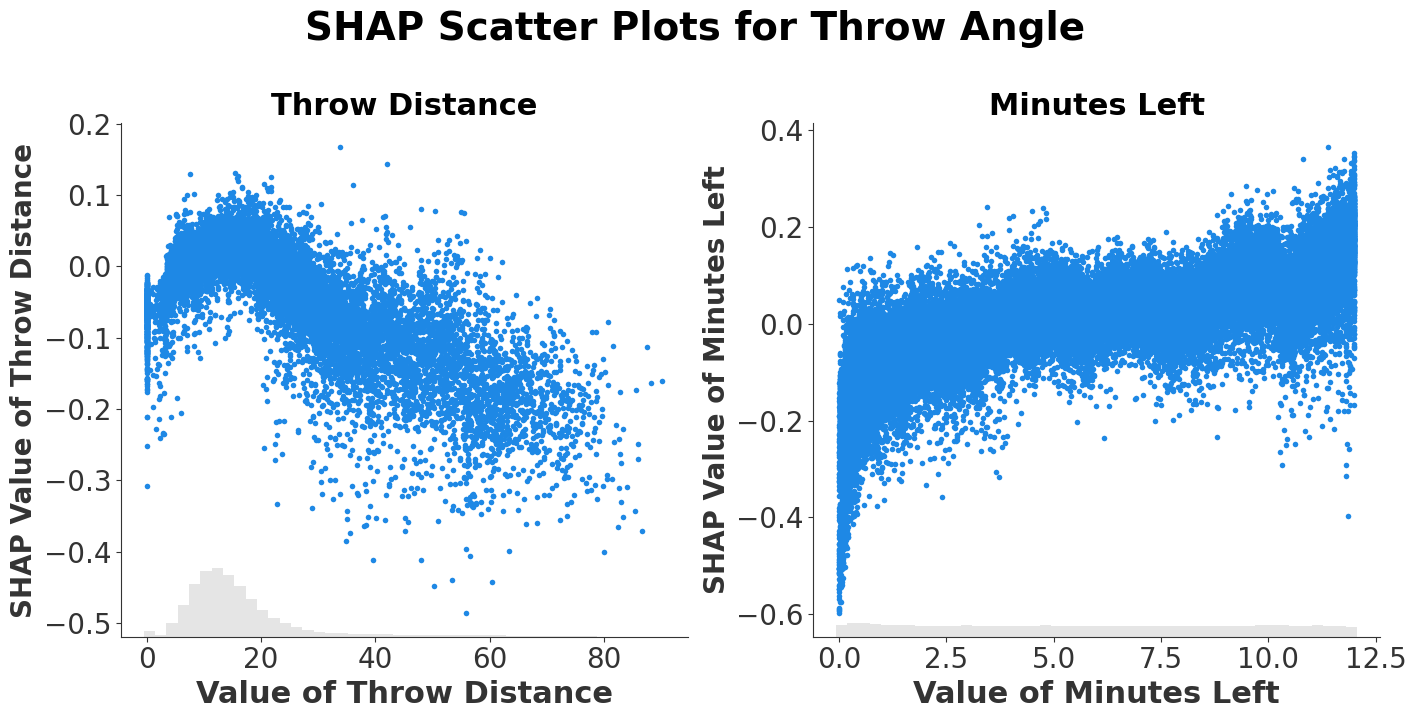

In [34]:
vals = etv_shap_values
feature='throw angle'
interaction_indices = shap.approximate_interactions(
    vals.feature_names.index(feature),
    vals.values,
    vals.data,
    feature_names=vals.feature_names
)
top_features_indices = interaction_indices[:4]
top_features = [vals.feature_names[i] for i in top_features_indices]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes = axes.flatten()

for i, chosen_feature in enumerate(['throw distance', 'time left']):
    shap.plots.scatter(vals[:, chosen_feature], show=False, ax=axes[i])
    chosen_feature = chosen_feature.replace('time', 'minutes')
    axes[i].set_title(f'{chosen_feature}'.title(), fontweight='bold', fontsize=22)  # Bold title
    axes[i].set_xlabel(f'Value of {chosen_feature.title()}', fontweight='bold', fontsize=22)  # Bold x-label
    axes[i].set_ylabel(f'SHAP Value of {chosen_feature.title()}', fontweight='bold', fontsize=20)  # Bold y-label

    axes[i].tick_params(axis='both', labelsize=20)


plt.suptitle(f'SHAP Scatter Plots for {feature.title()}', fontsize=28, fontweight='bold', y=1.02)  # Bold main title
plt.tight_layout()

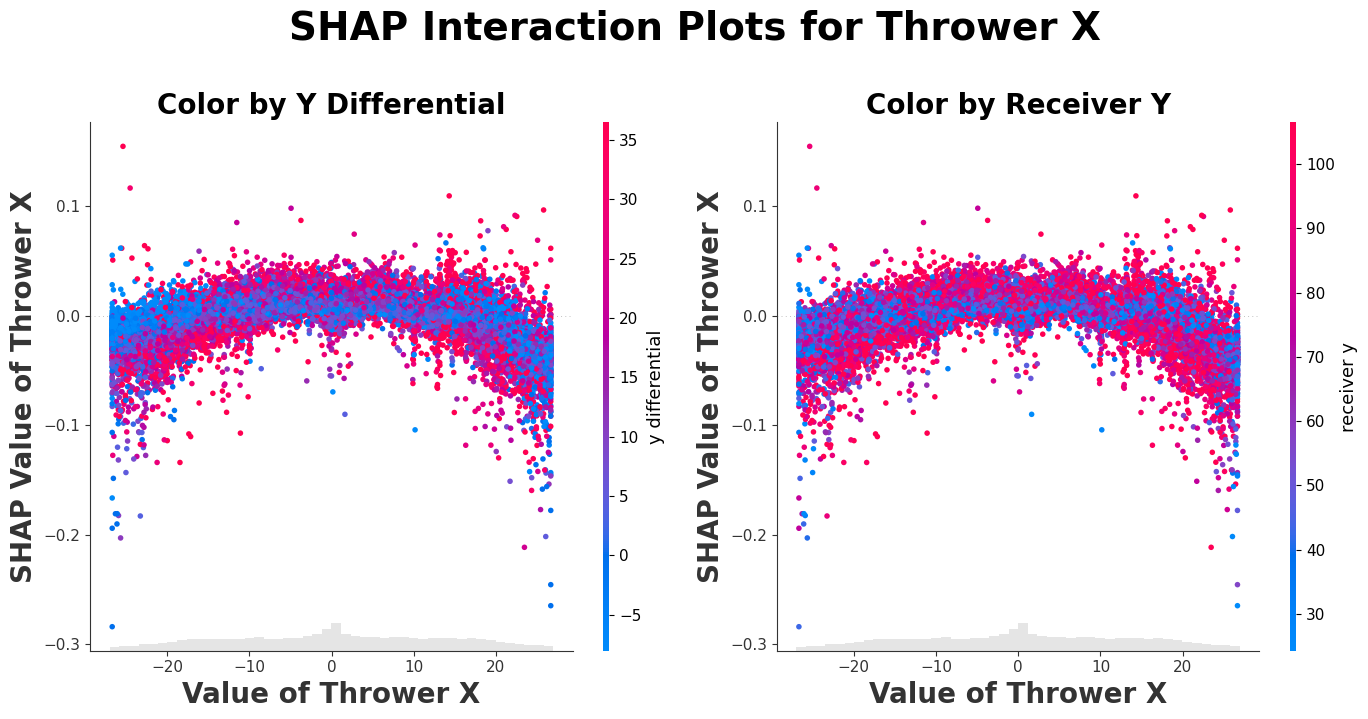

In [18]:
feature = 'thrower x'
top_features = ['y differential', 'receiver y']
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes = axes.flatten()
vals = etv_shap_values

for i, chosen_feature in enumerate(top_features):
    shap.plots.scatter(vals[:, feature], color=vals[:, chosen_feature], show=False, ax=axes[i])
    axes[i].set_title(f'Color by {chosen_feature.title()}', fontweight='bold', fontsize=20)  # Bold title
    axes[i].set_xlabel(f'Value of {feature.title()}', fontweight='bold', fontsize=20)  # Bold x-label
    axes[i].set_ylabel(f'SHAP Value of {feature.title()}', fontweight='bold', fontsize=20)  # Bold y-label
    # axes[i].tick_params(labelweight='bold')  # Bold tick labels

plt.suptitle(f'SHAP Interaction Plots for {feature.title()}', fontsize=28, fontweight='bold', y=1.02)  # Bold main title
plt.tight_layout()

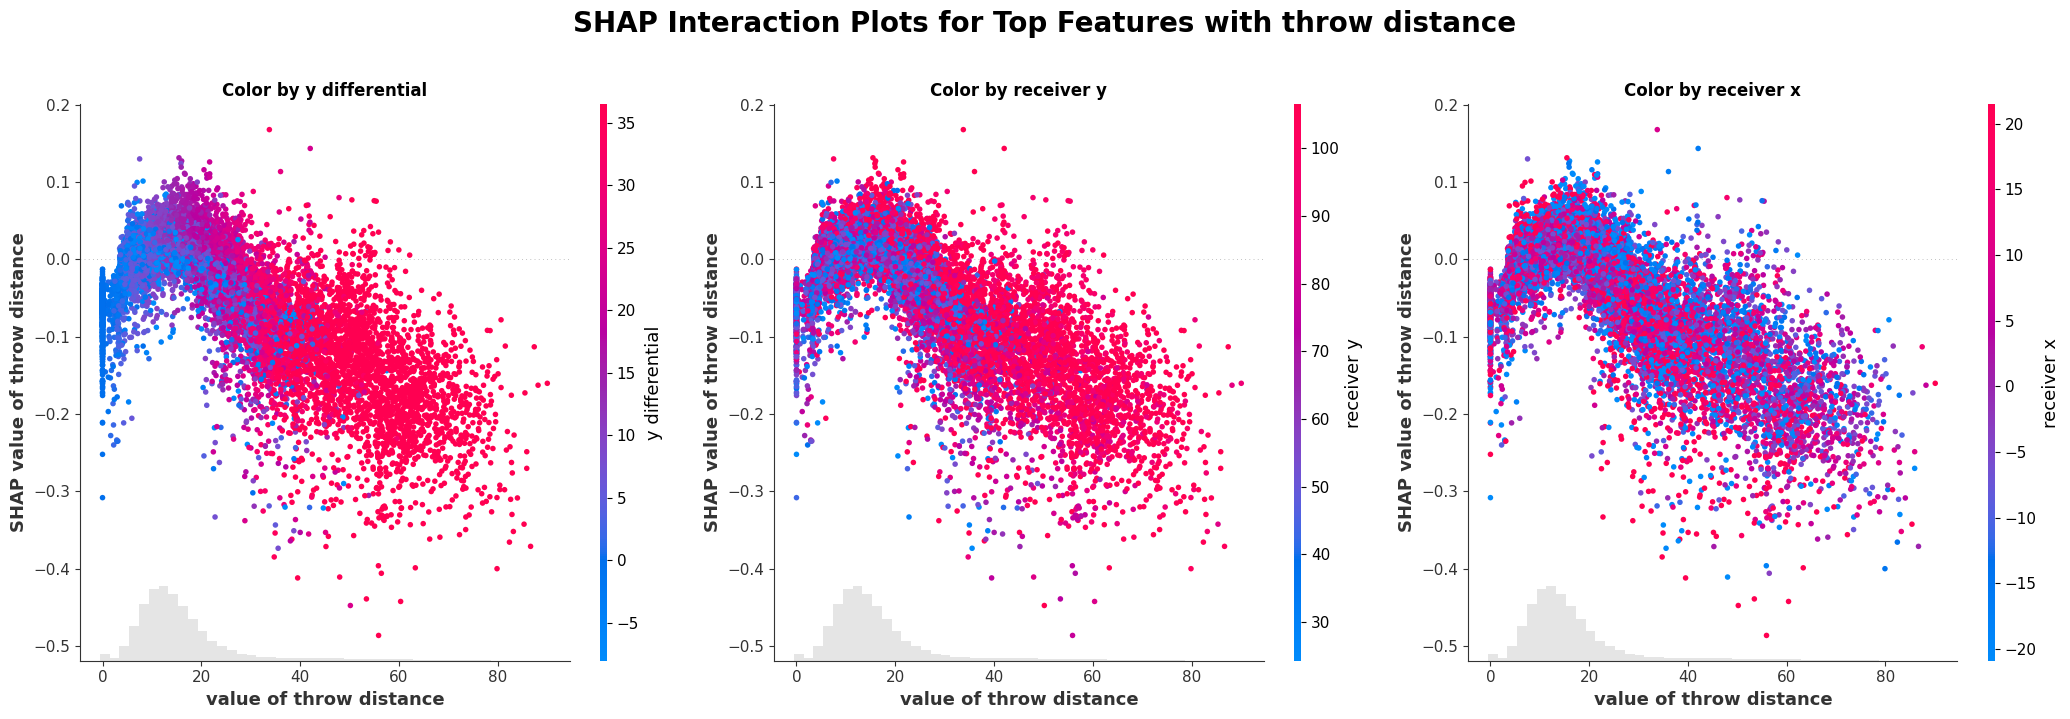

In [9]:
feature = 'throw distance'
top_features = ['y differential', 'receiver y', 'receiver x']
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
axes = axes.flatten()

for i, chosen_feature in enumerate(top_features):
    shap.plots.scatter(vals[:, feature], color=vals[:, chosen_feature], show=False, ax=axes[i])
    axes[i].set_title(f'Color by {chosen_feature}', fontweight='bold')  # Bold title
    axes[i].set_xlabel(f'value of {feature}', fontweight='bold')  # Bold x-label
    axes[i].set_ylabel(f'SHAP value of {feature}', fontweight='bold')  # Bold y-label
    # axes[i].tick_params(labelweight='bold')  # Bold tick labels

plt.suptitle(f'SHAP Interaction Plots for Top Features with {feature}', fontsize=20, fontweight='bold', y=1.02)  # Bold main title
plt.tight_layout()

CP Model SHAP

In [10]:
X = test_df_random[models['cp_model']['features']].astype(float).iloc[:20000,:]
explainer = shap.Explainer(models['cp_model']['model'].predict, X)
cp_shap_values = explainer(X)
cp_shap_values.feature_names = [x.replace('_', ' ').replace('possession num', 'number of possessions in current point').replace('times', 'time left').replace('diff', 'differential').replace('possession throw', 'number of throws in current possession') for x in cp_shap_values.feature_names]
joblib.dump(cp_shap_values, './shap_values/cp_shap_values.jblb')

PermutationExplainer explainer: 20001it [26:28, 12.52it/s]                           


['./shap_values/cp_shap_values.jblb']

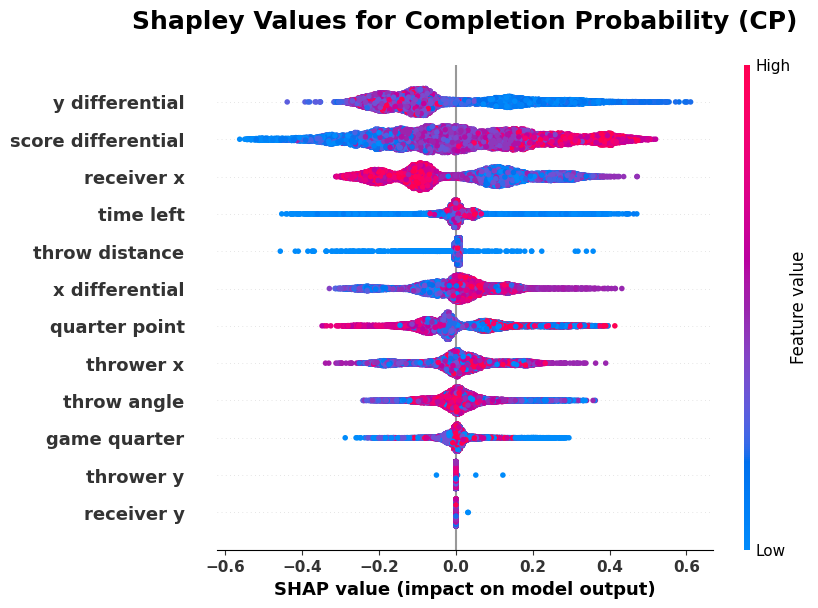

In [11]:
shap.plots.beeswarm(cp_shap_values, max_display=15, show=False, order=cp_shap_values.abs.max(0))
plt.title("Shapley Values for Completion Probability (CP)\n")
# Customize the plot to make text bold
plt.title(plt.gca().get_title(), fontweight='bold', fontsize=18)  # Make the title bold
plt.xlabel(plt.gca().get_xlabel(), fontweight='bold')  # Make the x-axis label bold
plt.ylabel(plt.gca().get_ylabel(), fontweight='bold')  # Make the y-axis label bold

# Set bold font for the tick labels
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()

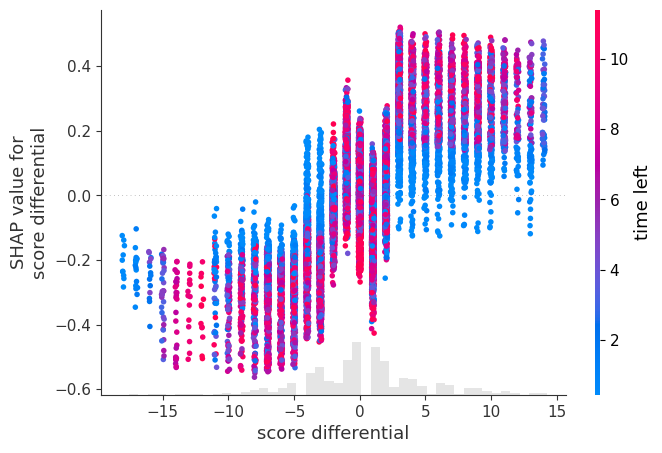

In [12]:
shap.plots.scatter(cp_shap_values[:, "score differential"], color=cp_shap_values)

In [13]:
X = test_df_random[models['fv_model']['features']].astype(float).iloc[:20000,:]
explainer = shap.Explainer(models['fv_model']['model'].predict, X)
fv_shap_values = explainer(X)
fv_shap_values.feature_names = [x.replace('_', ' ').replace('possession num', 'number of possessions in current point').replace('times', 'time left').replace('diff', 'differential').replace('possession throw', 'number of throws in current possession') for x in fv_shap_values.feature_names]
joblib.dump(fv_shap_values, './shap_values/fv_shap_values.jblb')

ExactExplainer explainer: 20001it [02:12, 140.36it/s]                           


['./shap_values/fv_shap_values.jblb']

FV SHAP

In [14]:
fv_shap_values = joblib.load('./shap_values/fv_shap_values.jblb')

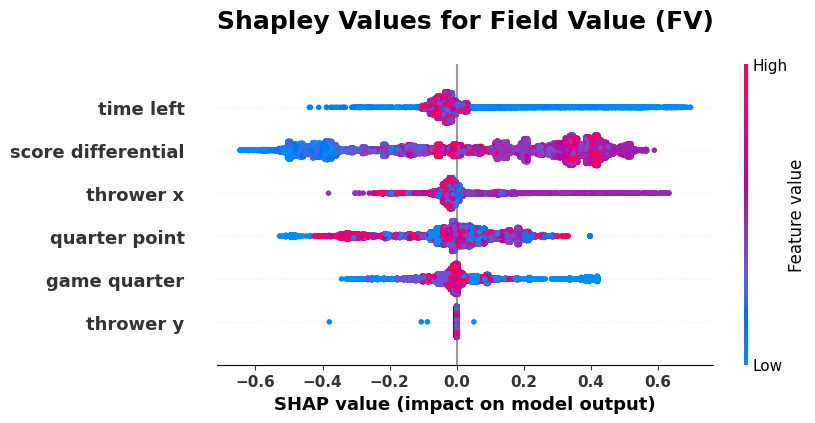

In [15]:
shap.plots.beeswarm(fv_shap_values, max_display=15, show=False, order=fv_shap_values.abs.max(0))
plt.title("Shapley Values for Field Value (FV)\n")
# Customize the plot to make text bold
plt.title(plt.gca().get_title(), fontweight='bold', fontsize=18)  # Make the title bold
plt.xlabel(plt.gca().get_xlabel(), fontweight='bold')  # Make the x-axis label bold
plt.ylabel(plt.gca().get_ylabel(), fontweight='bold')  # Make the y-axis label bold

# Set bold font for the tick labels
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')

plt.show()

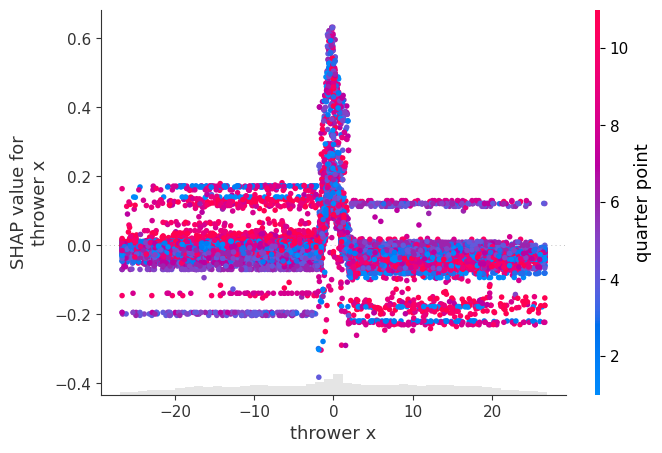

In [16]:
shap.plots.scatter(fv_shap_values[:, "thrower x"], color=fv_shap_values)